In [1]:
# for directory navigation 
import os

# for scraping html files
from bs4 import BeautifulSoup

# for tokenization, lemmatization and stemming
import nltk
from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()
from nltk.stem import PorterStemmer
pst = PorterStemmer()

# for parsing noun phrases
import spacy
nlp = spacy.load("en_core_web_sm")

# get a list of stopwords from spacy
stopwords = nlp.Defaults.stop_words

# for generating word clouds and plotting
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [2]:
path = '../_site/'  # local directory containing the webpages
data = []

for root, dirs, files in os.walk(path):
    for f in files:
        
        # Get all html files in all subdirectories under 'path'
        if f.endswith(".html") and f != '404.html':  # exclude '404.html'
            filename = os.path.join(root, f)
            
            # Read each html file into a 'soup' object
            with open(filename, 'r', encoding="utf8") as raw:
                soup = BeautifulSoup(raw.read(), 'html5lib')
                # Get all 'p' elements in a file and append them to 'data'
                data.append(soup.find_all('p'))

# 'data' is a list of lists. Flatten it first before further processing:
data = [s.text for sublist in data for s in sublist]

# remove newline tags
data = [s.replace('\n', ' ') for s in data]

In [3]:
# remove stopwords
data_no_sw = []
for s in data:
    s_no_sw = ' '.join([t for t in s.split() if not t.lower() in stopwords])
    if s_no_sw:
        data_no_sw.append(s_no_sw)

# get a dict with stems as keys and lemmas as values; only look at nouns
stem_dict = {}
for s in data_no_sw:
    # get lemmas of all tokens in 's':
    # tokens are converted to lowercase first to avoid mis-lemmatizing
    # (eg. "Currently" mis-lemmatized as "Currently"(noun) instead of "current")
    lems = [wnl.lemmatize(t.lower(), 'n') for t in nltk.word_tokenize(s)]
    # get the stems of nouns only; construct the dict:
    stem_dict.update({pst.stem(t) : t 
                      for t, pos in nltk.pos_tag(lems) if pos.startswith('N')})

# get nouns of all noun derivatives
dev_n = []
for s in data_no_sw:
    # get stems of all tokens in 's':
    stems = [pst.stem(t.lower()) for t in nltk.word_tokenize(s)]
    # if a stem is found in 'stem_dict', add the corresponding noun to 'n_dev':
    [dev_n.append(stem_dict[t]) for t in stems 
     if t in stem_dict and t not in ['’','s']]  # also remove '’' and 's' 

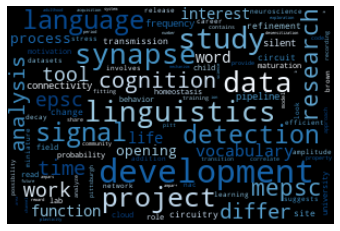

In [4]:
# Generate word cloud from nouns and derived nouns

# Get word frequencies
freq = nltk.FreqDist(dev_n)

# generate word cloud
wc = WordCloud(max_font_size=30, width=300, max_words=100, prefer_horizontal=0.9,
               colormap='Blues', random_state=1).generate_from_frequencies(freq)

# plot word cloud
plt.axis("off")
plt.imshow(wc, interpolation='bilinear')
plt.show()

# export word cloud to svg file
wc_svg = wc.to_svg(embed_font=True)
with open("../img/wordcloud_nouns.svg","w+", encoding="utf-8") as f:  # use utf-8 for chinese characters
    f.write(wc_svg)


In [5]:
# get noun chunks using spacy
chunks = []
for doc in nlp.pipe(data):
    [chunks.append(c.text) for c in doc.noun_chunks]

# clean data
n_phrases = []
for c in chunks:    
    # remove stopwords:
    c_no_sw = ' '.join([t for t in c.split() if not t.lower() in stopwords])
    # change plural phrases to singular by lemmatizing last word of the phrase
    if c_no_sw:
        toks = c_no_sw.split()
        last_lem = wnl.lemmatize(toks[-1], 'n')  # get lemma of last token
        toks[-1] = last_lem  # replace last token with its lemma
        n_phrases.append(' '.join(toks))

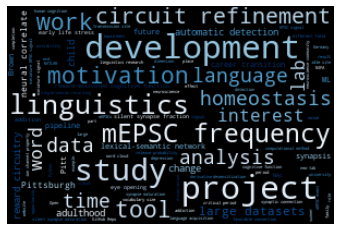

In [6]:
# Generate word cloud from noun phrases

# Get word frequencies
freq = nltk.FreqDist(n_phrases)

# generate word cloud
wc = WordCloud(max_font_size=30, width=300, prefer_horizontal=0.7,
               colormap='Blues', random_state=7).generate_from_frequencies(freq)

# plot word cloud
plt.axis("off")
plt.imshow(wc, interpolation='bilinear')
plt.show()

# export word cloud to svg file
wc_svg = wc.to_svg(embed_font=True)
with open("../img/wordcloud_phrases.svg","w+", encoding="utf-8") as f:  # use utf-8 for chinese characters
    f.write(wc_svg)